# 1141ML Final - DSM 2D

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")
## ---參數跟之前差不多

sigma_dsm=0.2
batch_size=2048


In [16]:
def sample_noisy_x_2d(batch_size, sigma):
    # 定義兩個 2D 高斯的 mean
    mu1 = np.array([-2, 0], dtype=np.float32)
    mu2 = np.array([ 2, 0], dtype=np.float32)

    # 抽 mixture component
    w = np.random.rand(batch_size) < 0.5
    x = np.zeros((batch_size, 2), dtype=np.float32)

    x[w]  = mu1 + np.random.randn(w.sum(),  2).astype(np.float32)
    x[~w] = mu2 + np.random.randn((~w).sum(), 2).astype(np.float32)

    # 加噪
    eps = np.random.randn(batch_size, 2).astype(np.float32)
    x_tilde = x + sigma * eps

    return x_tilde, eps


In [17]:
class ScoreNet(nn.Module):
    ## x_dim : 整個資料的維度
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim))  # output same dimension

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = ScoreNet(x_dim=2, hidden=128, num_layers=4).to(device)


In [18]:
def dsm_loss_step_2d():
    x_tilde_np, eps_np = sample_noisy_x_2d(batch_size, sigma_dsm)

    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    s_hat = model(x_tilde)

    # 正確 DSM target（2D）
    target = -eps / sigma_dsm

    loss = ((s_hat - target)**2).mean()
    return loss


In [19]:
#### Training Loop
num_steps=5000
lr=5e-3

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # lr = lr * 0.5
    patience=200,     # 若 200 steps 沒有改善就降低 lr
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step_2d()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # scheduler 可有可無
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 23.822542 | lr = 0.005000
step  400 | loss = 24.431793 | lr = 0.005000
step  600 | loss = 25.025980 | lr = 0.005000
step  800 | loss = 25.116802 | lr = 0.005000
step 1000 | loss = 24.898531 | lr = 0.005000
step 1200 | loss = 23.223629 | lr = 0.005000
step 1400 | loss = 23.512751 | lr = 0.005000
step 1600 | loss = 24.898277 | lr = 0.005000
step 1800 | loss = 24.947313 | lr = 0.005000
step 2000 | loss = 22.910345 | lr = 0.005000
step 2200 | loss = 23.260006 | lr = 0.005000
step 2400 | loss = 24.317541 | lr = 0.005000
step 2600 | loss = 24.383259 | lr = 0.005000
step 2800 | loss = 25.390091 | lr = 0.005000
step 3000 | loss = 24.392258 | lr = 0.005000
step 3200 | loss = 23.996803 | lr = 0.005000
step 3400 | loss = 24.499907 | lr = 0.005000
step 3600 | loss = 24.275402 | lr = 0.005000
step 3800 | loss = 24.105549 | lr = 0.005000
step 4000 | loss = 24.243759 | lr = 0.005000
step 4200 | loss = 25.122513 | lr = 0.005000
step 4400 | loss = 24.156551 | lr = 0.005000
step 4600 

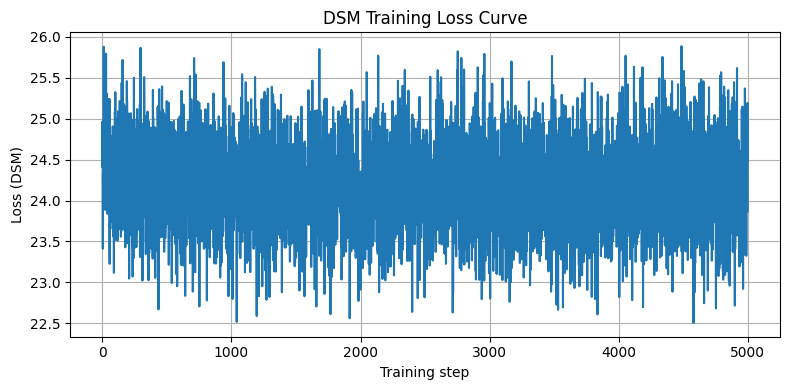

In [21]:

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

In [20]:
print(sigma_dsm)

0.2


## 2D Langevin Sampling

In [22]:
def langevin_sampling_2d(model, steps=3000, eta=0.002):
    model.eval()
    x = torch.randn(5000, 2).to(device)
    sqrt_term = torch.sqrt(torch.tensor(2*eta, device=device))

    for _ in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + sqrt_term * noise

    return x.detach().cpu().numpy()


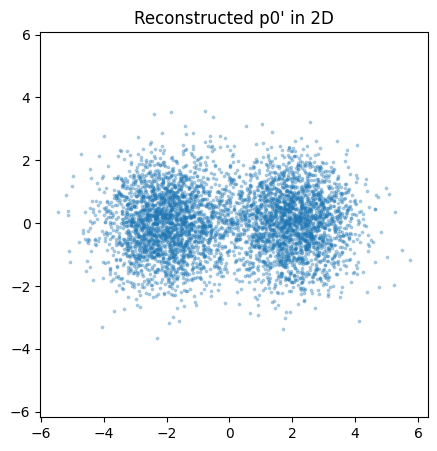

In [23]:
samples = langevin_sampling_2d(model)

plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], s=3, alpha=0.3)
plt.title("Reconstructed p0' in 2D")
plt.axis("equal")
plt.show()
